In [1]:
import math
import numpy as np
import re
import os

from numpy import argmax
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# Setup PATH and folder of images
directory = "/home/fizzer/Desktop/353_ws/plates/labelled"
labels = ['plates']
# print(labels)

In [3]:
alphanumeric = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# Create mappings
char_to_int = dict((c, i) for i, c in enumerate(alphanumeric))
int_to_char = dict((i, c) for i, c in enumerate(alphanumeric))

# Invert one hot encode
def invert_one_hot(data):
    return int_to_char[argmax(data)]

def get_char(char):
    return int_to_char[char]

def get_int(data):
    return char_to_int[data]

In [4]:
plateNames = []
os.chdir(directory)
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        plate = filename.rsplit('.',1)
        plateNames.append(plate[0])
    else:
        continue  
# print(plateNames)
# # Character positions on license plate\n",
crop_size = (100, 50, 3)

lchar0 = (10,0,60,100)
lchar1 = (55,0,105,100)
lchar2 = (100,0,150,100)
lchar3 = (145,0,195,100)
license_char = [lchar0, lchar1, lchar2, lchar3]

pchar0 = (35,0,85,100)
pchar1 = (80,0,130,100)
pchar2 = (125,0,175,100)
parking_char = [pchar0, pchar1, pchar2]

imgset = []
plateset = []
img_validset = []
plate_validset = []
img_leftover = []
plate_leftover = []
char_count = [0] * 36

for plate in plateNames:
    length = len(plate)
    if length != 0:
        if length == 4:
            char_set = license_char
        elif length == 3:
            char_set = parking_char
        image = Image.open(plate+".jpg")

        for i in range(length):
            char_int = get_int(plate[i])
            if length == 3:
                crop = image.crop(char_set[i])
                imgset.append(np.array(crop))
                plateset.append(np.array(plate[i]))
                imgset.append(np.array(crop)) # Duplicate parking plates
                plateset.append(np.array(plate[i]))
                char_count[char_int] += 2
            elif char_count[char_int] < 20:
                crop = image.crop(char_set[i])
                imgset.append(np.array(crop))
                plateset.append(np.array(plate[i]))
                char_count[char_int] += 1
            elif char_count[char_int] < 25:
                crop = image.crop(char_set[i])
                img_validset.append(np.array(crop))
                plate_validset.append(np.array(plate[i]))
                char_count[char_int] += 1

            else:
                crop = image.crop(char_set[i])
                img_leftover.append(np.array(crop))
                plate_leftover.append(np.array(plate[i]))
                char_count[char_int] += 1
    else:
        continue
        
X_data_orig = np.array(imgset)
Y_data_orig = np.array(plateset)
X_validate_set = np.array(img_validset)
Y_validate_set = np.array(plate_validset)
X_leftover = np.array(img_leftover)
Y_leftover = np.array(plate_leftover)
print(char_count)
# print(plateNames)

[32, 30, 33, 34, 30, 32, 34, 31, 33, 30, 37, 31, 30, 32, 34, 47, 35, 32, 31, 33, 33, 30, 33, 31, 33, 31, 119, 87, 86, 77, 92, 80, 74, 96, 76, 97]


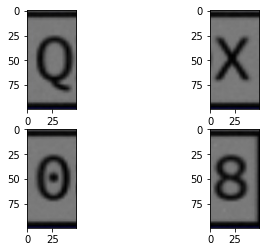

In [5]:
# Check slices of image
plateNumber = 29

plateCheck = plateNames[plateNumber]
length = len(plateCheck)
if length == 4:
    char_set = license_char
if length == 3:
    char_set = parking_char
    
image = Image.open(plateCheck+".jpg")

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
crop0 = image.crop(char_set[0])
ax1.imshow(crop0)
ax2 = fig.add_subplot(2,2,2)
crop1 = image.crop(char_set[1])
ax2.imshow(crop1)
ax3 = fig.add_subplot(2,2,3)
crop2 = image.crop(char_set[2])
ax3.imshow(crop2)

if length == 4:
    ax4 = fig.add_subplot(2,2,4)
    crop3 = image.crop(char_set[3])
    ax4.imshow(crop3)


In [6]:
NUMBER_OF_LABELS = 36
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    alphanumeric = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    # Create mappings
    char_to_int = dict((c, i) for i, c in enumerate(alphanumeric))
    int_to_char = dict((i, c) for i, c in enumerate(alphanumeric))
    
    # Encodes the alphanumeric into its enumerated value
    integer_encoded = np.array([char_to_int[char] for char in Y])
    Y = np.eye(C)[integer_encoded.reshape(-1)].T
    return Y

# Normalize Image dataset
X_dataset = X_data_orig/255.0
X_validate = X_validate_set/255.0
X_leftover_check = X_leftover/255.0

# Conver Y dataset to on-hot encoding
Y_dataset = convert_to_one_hot(Y_data_orig, NUMBER_OF_LABELS).T
Y_validate = convert_to_one_hot(Y_validate_set, NUMBER_OF_LABELS).T
Y_leftover_check = convert_to_one_hot(Y_leftover, NUMBER_OF_LABELS).T

In [7]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0] + X_validate.shape[0],
             X_dataset.shape[0],
             X_validate.shape[0]))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

characters = np.sum(Y_dataset, axis = 0)
pair = []
for i, e in enumerate(alphanumeric):
    pair.append([alphanumeric[i],int(characters[i])])
pair.sort(key=lambda x:x[1])
print(pair)

Total examples: 970
Training examples: 803
Test examples: 167
X shape: (803, 100, 50, 3)
Y shape: (803, 36)
[['A', 20], ['B', 20], ['C', 20], ['D', 20], ['E', 20], ['F', 20], ['G', 20], ['H', 20], ['I', 20], ['J', 20], ['K', 20], ['L', 20], ['M', 20], ['N', 20], ['O', 20], ['Q', 20], ['R', 20], ['S', 20], ['T', 20], ['U', 20], ['V', 20], ['W', 20], ['X', 20], ['Y', 20], ['Z', 20], ['7', 22], ['8', 22], ['9', 22], ['2', 24], ['3', 24], ['4', 24], ['5', 24], ['6', 24], ['1', 37], ['P', 40], ['0', 40]]


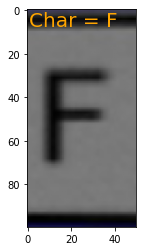

In [17]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set.
def displayImage(index):
    plt.imshow(X_dataset[index])
    
    invert_Y_data = invert_one_hot(Y_dataset[index])
    
    caption = ("Char = " + str(invert_Y_data))#str(np,squeeze(Y_data_orig[:, index]))
    plt.text(0.5, 0.5, caption,
             color='orange', fontsize = 20,
             horizontalalignment = 'left', verticalalignment = 'top')
        
    # interact(displayImage, 
#         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
#                                    step=1, value=10))
displayImage(69)

In [8]:
# Start Training Convolution Neural Network
from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend

Using TensorFlow backend.
/home/fizzer/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fizzer/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fizzer/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fizzer/.local/lib/python3.6/site-packages/tensorflow/python

In [11]:
# Reset weights
# - reinitializing the model parameters
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernal_initalizer'):
            layer.kernal.initializer.run(session=session)

In [12]:
# Model definition
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=crop_size))
conv_model.add(layers.MaxPool2D((2,2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))
conv_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 37632)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               19268096  
_________________________________________________________________
dense_2 (Dense)              (None, 36)                18468     
Total params: 19,287,460
Trainable params: 19,287,460
Non-trainable params: 0
_________________________________________

In [13]:
# Loss function and learning rate
# Can change loss rate to see what happens
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [14]:
reset_weights(conv_model)

In [15]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=40, 
                              batch_size=16)


Train on 467 samples, validate on 117 samples
Epoch 1/50
467/467 [==============================] - 5s 11ms/step - loss: 3.4758 - acc: 0.0814 - val_loss: 3.4716 - val_acc: 0.0427
Epoch 2/50
467/467 [==============================] - 5s 10ms/step - loss: 3.1856 - acc: 0.2141 - val_loss: 3.1515 - val_acc: 0.1538
Epoch 3/50
467/467 [==============================] - 5s 11ms/step - loss: 2.8760 - acc: 0.3191 - val_loss: 2.9074 - val_acc: 0.2308
Epoch 4/50
467/467 [==============================] - 5s 11ms/step - loss: 2.5427 - acc: 0.4218 - val_loss: 2.8803 - val_acc: 0.2137
Epoch 5/50
467/467 [==============================] - 5s 11ms/step - loss: 2.2094 - acc: 0.4968 - val_loss: 2.4707 - val_acc: 0.3590
Epoch 6/50
467/467 [==============================] - 5s 11ms/step - loss: 1.9089 - acc: 0.5653 - val_loss: 2.3144 - val_acc: 0.3846
Epoch 7/50
467/467 [==============================] - 5s 11ms/step - loss: 1.6385 - acc: 0.6124 - val_loss: 2.1279 - val_acc: 0.3504
Epoch 8/50
467/467 [==

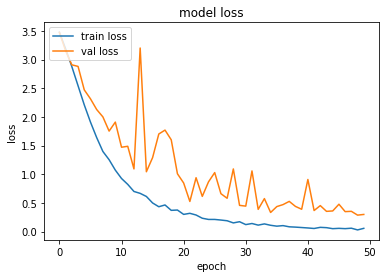

In [16]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

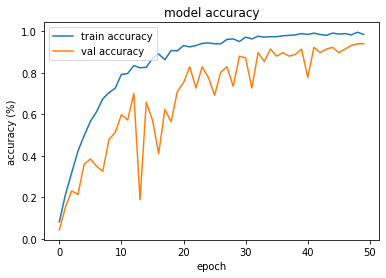

In [17]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [9]:
# from keras.models import load_model
# conv_model = load_model("/home/fizzer/Desktop/353_ws/neural_net/alphanumeric_model.h5")

(100, 50, 3)
(1, 100, 50, 3)


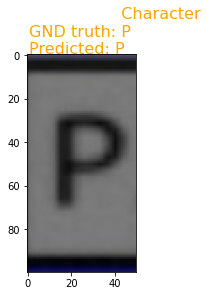

In [19]:
# Display images in the training data set. 
def displayImage(index):
    img = X_dataset[index]

    print(img.shape)
    
    img_aug = np.expand_dims(img, axis=0)
    print(img_aug.shape)
    y_predict = conv_model.predict(img_aug)[0]

    plt.figure()
    plt.imshow(img)  
    caption = ("                  Character\n"+
             "GND truth: {:.2}\nPredicted: {:.2}".
             format(invert_one_hot(Y_dataset[index]),  
                    get_char(np.argmax(y_predict))))
    plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom') 

# interact(displayImage, 
#         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
#                                    step=1, value=10))

displayImage(4)



Confusion matrix, without normalization
[[37  0  0 ...  0  0  0]
 [ 0 34  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 10]]
Normalized confusion matrix
[[0.95 0.   0.   ... 0.   0.   0.  ]
 [0.   0.97 0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]


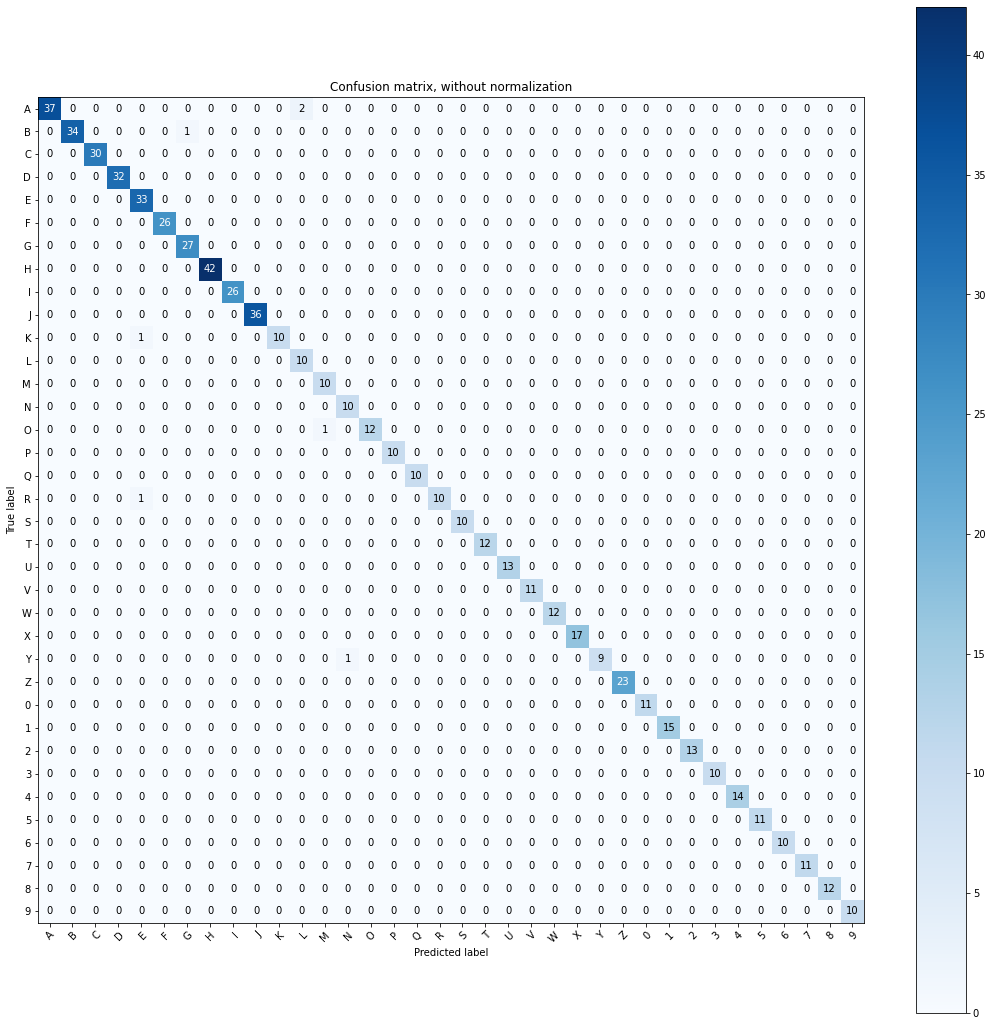

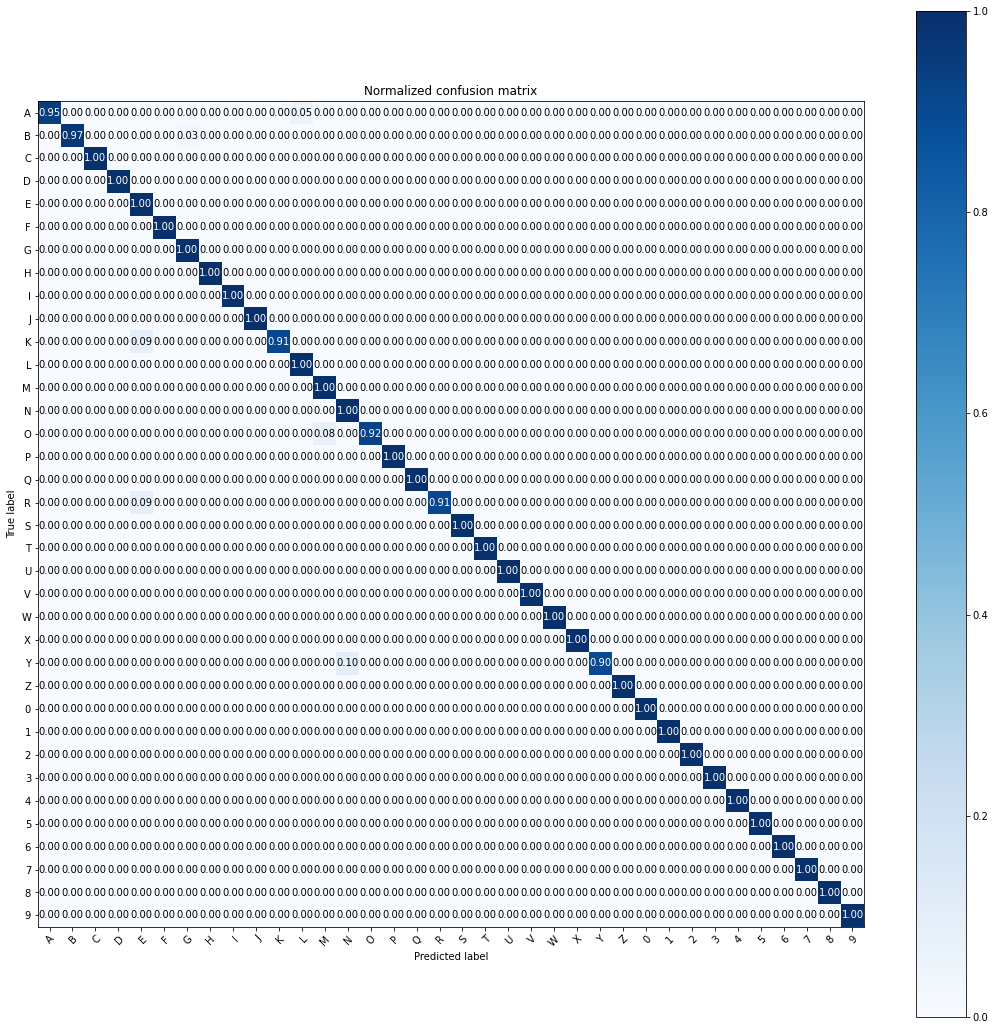

In [11]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
         'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
         'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2',
         '3', '4', '5', '6', '7', '8', '9']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    fig.set_size_inches(18.5,18.5)
    return ax

np.set_printoptions(precision=2)

y_true = []
y_predict = []

for index in range(Y_dataset.shape[0]):
    img = X_dataset[index]

    img_aug = np.expand_dims(img, axis=0)
    y_predict.append(get_char(np.argmax(conv_model.predict(img_aug)[0])))
    y_true.append(get_char(np.argmax(Y_dataset[index])))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_predict, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_predict, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# print(y_predict)
# print(y_true)

In [14]:
import keras
keras.__version__

'2.3.1'

In [ ]:
conv_model.save(\"/home/fizzer/Desktop/353_ws/neural_net/Apr14.h5\")